https://www.kaggle.com/code/sercanyesiloz/electricity-production-forecasting-arima/notebook

In [45]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from pandas import DataFrame
from pandas import concat
import numpy as np
from math import sqrt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [27]:
col_names = ["date", "value"]
df = pd.read_csv('data/Electric_Production.csv',
                 names = col_names, header = 0, parse_dates = [0])
df['date'] = pd.to_datetime(df['date'],infer_datetime_format=True)
df = df.set_index(['date'])
df.head()

,value
date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


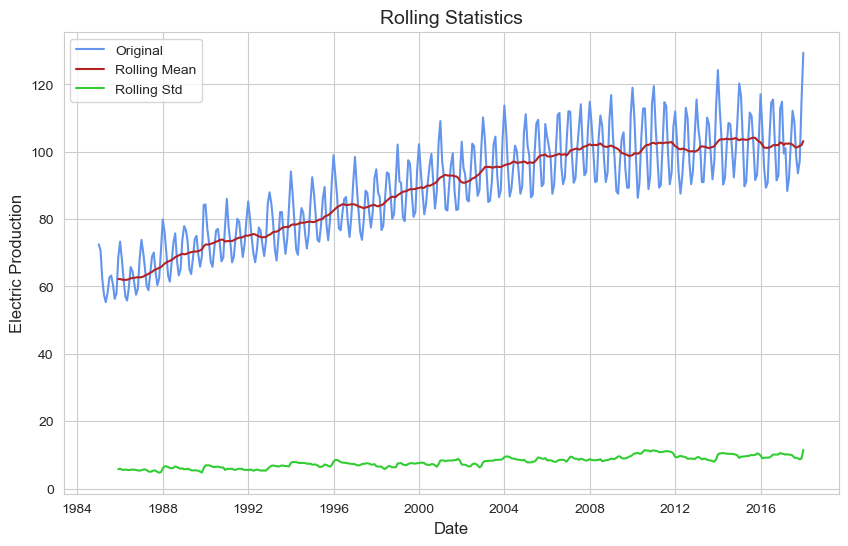

In [28]:
# Analyse
rolling_mean = df.rolling(window=12).mean()
rolling_std = df.rolling(window=12).std()
plt.figure(figsize = (10,6))
plt.plot(df, color='cornflowerblue', label='Original')
plt.plot(rolling_mean, color='firebrick', label='Rolling Mean')
plt.plot(rolling_std, color='limegreen', label='Rolling Std')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size  = 12)
plt.legend(loc = 'upper left')
plt.title('Rolling Statistics', size = 14)
plt.show()


From the above graph, we see that rolling mean itself has a trend component even though rolling standard deviation is fairly constant with time. For our time series to be stationary, we need to ensure that both the rolling statistics ie: mean & std. dev. remain time invariant or constant with time. Thus the curves for both of them have to be parallel to the x-axis, which in our case is not so.

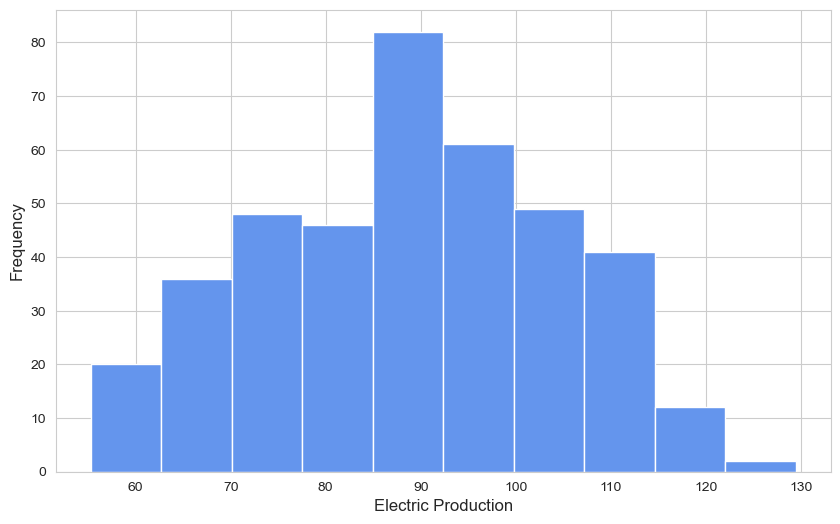

In [29]:
plt.figure(figsize = (10,6))
plt.hist(df['value'], color = 'cornflowerblue')
plt.xlabel('Electric Production', size = 12)
plt.ylabel('Frequency', size = 12)
plt.show()

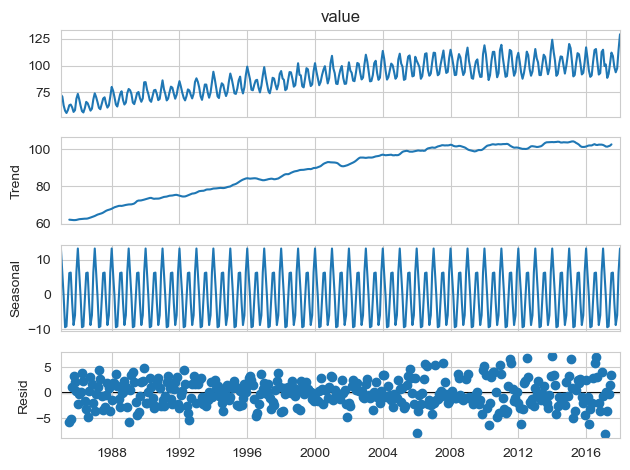

In [35]:
# Decomposing the data for better view of the data
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(x=df['value'],model='additive',period=12)
decomposition.plot()
plt.show()

In [30]:
adf = adfuller(df)
    
print('ADF Statistic: {}'.format(round(adf[0],3)))
print('p-value: {}'.format(round(adf[1],3)))
print("##################################")  
print('Critical Values:')

for key, ts in adf[4].items():
     print('{}: {}'.format(key, round(ts,3)))
print("##################################")

if adf[0] > adf[4]["5%"]:
    print("ADF > Critical Values")
    print ("Failed to reject null hypothesis, time series is non-stationary.")
else:
    print("ADF < Critical Values")
    print ("Reject null hypothesis, time series is stationary.")

ADF Statistic: -2.257
p-value: 0.186
##################################
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
##################################
ADF > Critical Values
Failed to reject null hypothesis, time series is non-stationary.


# Converting Data to Stationary## Logarithmic Transformation with Box-Cox




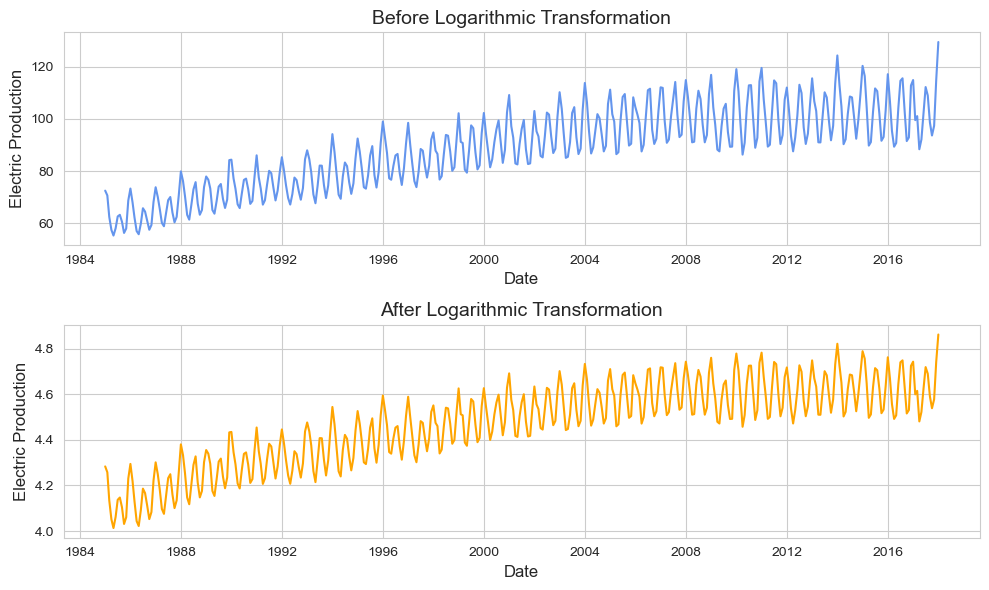

In [33]:
df_log_scaled = df.copy()

# df_log_scaled['value']=np.log(df_log_scaled)
from scipy import stats
df_log_scaled['value'] = boxcox(df_log_scaled['value'],lmbda=0.0)

plt.figure(figsize = (10,6))
plt.subplot(211)

plt.plot(df, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)

plt.title("Before Logarithmic Transformation", size = 14)

plt.subplot(212)

plt.plot(df_log_scaled, color = 'orange')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)

plt.title("After Logarithmic Transformation", size = 14)

plt.tight_layout()

plt.show()

## Removing Trend with Moving Average



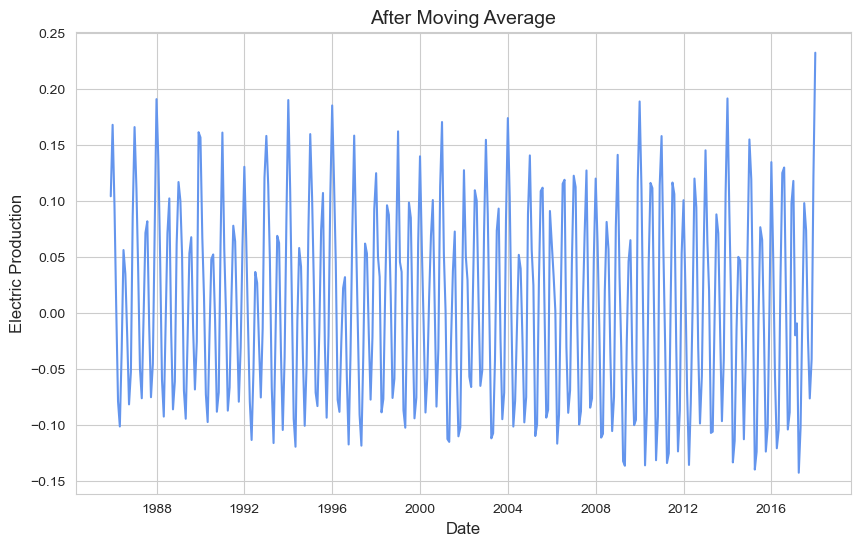

In [34]:
# making series trend stationary with moving average method
moving_avg = df_log_scaled.rolling(window=12).mean()
df_log_scaled_ma = df_log_scaled - moving_avg
df_log_scaled_ma.dropna(inplace=True)
plt.figure(figsize = (10,6))
plt.plot(df_log_scaled_ma, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Moving Average", size = 14)
plt.show()

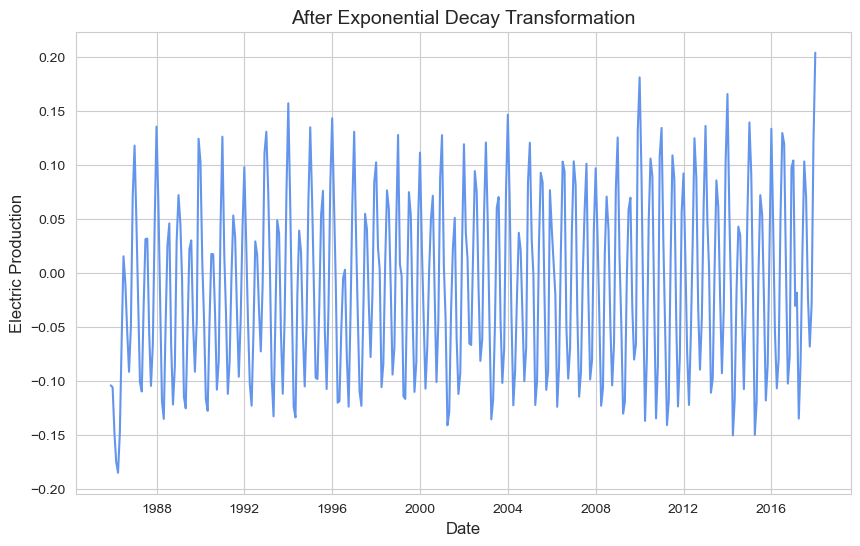

In [37]:
# making series trend stationary with moving average exponential decay method

df_log_scaled_ma_ed = df_log_scaled_ma.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_lsma_sub_df_lsma_ed = df_log_scaled_ma - df_log_scaled_ma_ed

plt.figure(figsize = (10,6))
plt.plot(df_lsma_sub_df_lsma_ed - df_log_scaled_ma_ed, color='cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Exponential Decay Transformation", size = 14)
plt.show()


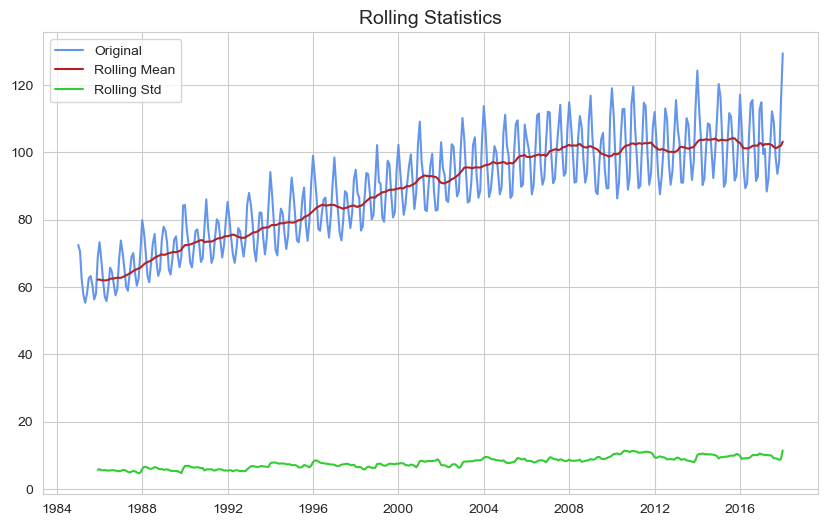

ADF Statistic: -2.257
p-value: 0.186
##################################
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
##################################
ADF > Critical Values
Failed to reject null hypothesis, time series is non-stationary.


In [41]:
#adfuller_test(df_lsma_sub_df_lsma_ed, window = 12)
def adfuller_test(ts, window = 12):
    
    movingAverage = ts.rolling(window).mean()
    movingSTD = ts.rolling(window).std()
    
    plt.figure(figsize = (10,6))
    orig = plt.plot(ts, color='cornflowerblue',
                    label='Original')
    mean = plt.plot(movingAverage, color='firebrick',
                    label='Rolling Mean')
    std = plt.plot(movingSTD, color='limegreen',
                   label='Rolling Std')
    plt.legend(loc = 'upper left')
    plt.title('Rolling Statistics', size = 14)
    plt.show(block=False)
    
    adf = adfuller(ts, autolag='AIC')
    
    print('ADF Statistic: {}'.format(round(adf[0],3)))
    print('p-value: {}'.format(round(adf[1],3)))
    print("##################################")  
    print('Critical Values:')
    
    for key, ts in adf[4].items():
         print('{}: {}'.format(key, round(ts,3)))
    print("##################################")
    
    if adf[0] > adf[4]["5%"]:
        print("ADF > Critical Values")
        print ("Failed to reject null hypothesis, time series is non-stationary.")
    else:
        print("ADF < Critical Values")
        print ("Reject null hypothesis, time series is stationary.")
        
adfuller_test(df, window = 12)

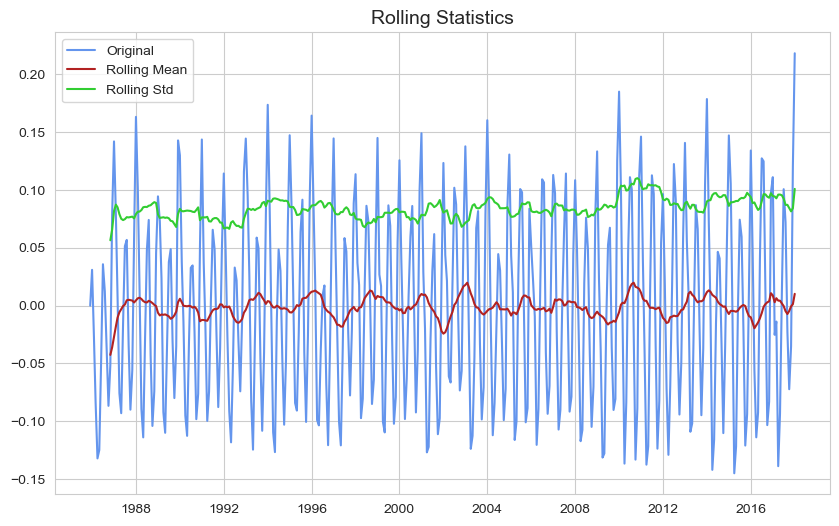

ADF Statistic: -7.213
p-value: 0.0
##################################
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
##################################
ADF < Critical Values
Reject null hypothesis, time series is stationary.


In [42]:
adfuller_test(df_lsma_sub_df_lsma_ed,window=12)

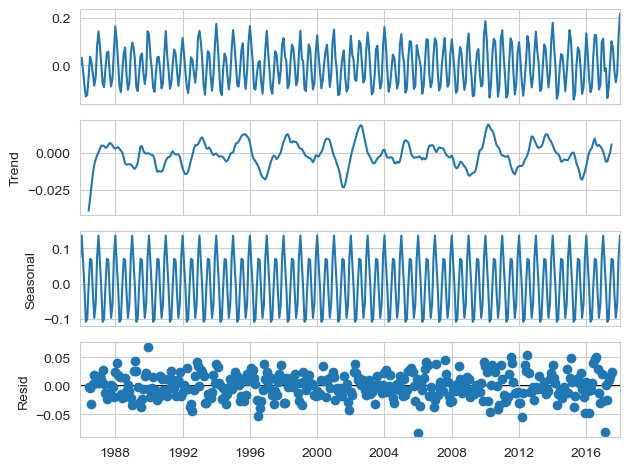

In [43]:
df_seasonal_decompose = seasonal_decompose(df_lsma_sub_df_lsma_ed, 
                                           model='duplicative')
df_seasonal_decompose.plot()
plt.show()

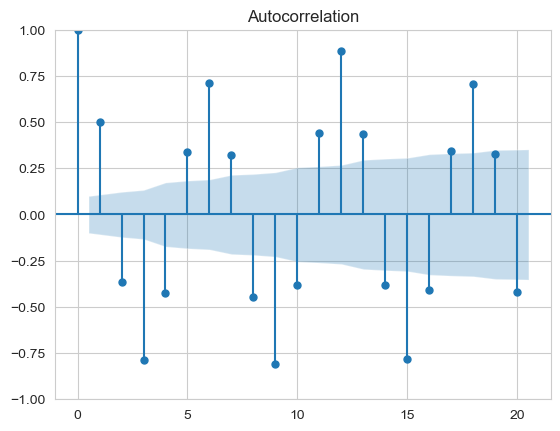

<Figure size 640x480 with 0 Axes>

In [50]:
# plot ACF and PACF

plot_acf(df_lsma_sub_df_lsma_ed, lags=20)

# fig, axs = plt.subplots(1, 2, figsize =(12,5))

# plt.subplot(121)
# plt.plot(auto_c_f)
# plt.axhline(y=0, linestyle='--', color='limegreen')
# plt.axhline(y=-1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
#             linestyle='--', color='firebrick')
# plt.axhline(y=1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
#             linestyle='--', color='firebrick')
# plt.title('Autocorrelation Function', size = 14)            

# plt.subplot(122)
# plt.plot(partial_auto_c_f)
# plt.axhline(y=0, linestyle='--', color='limegreen')
# plt.axhline(y=-1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
#             linestyle='--', color='firebrick')
# plt.axhline(y=1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
#             linestyle='--', color='firebrick')
# plt.title('Partial Autocorrelation Function', size = 14)
plt.show()
plt.tight_layout() 

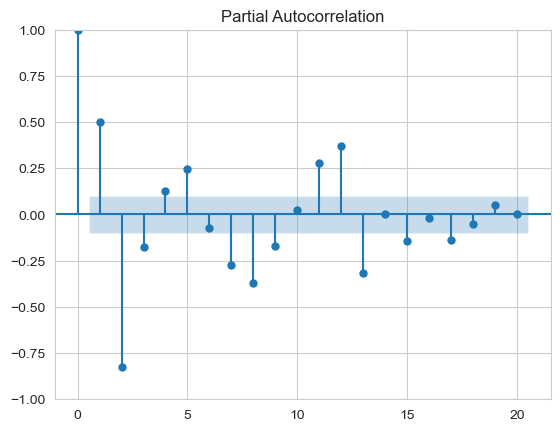

In [51]:
plot_pacf(df_lsma_sub_df_lsma_ed,lags =20)
plt.show()